In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uw-cs480-fall20/sample_submission.csv
/kaggle/input/uw-cs480-fall20/train.csv
/kaggle/input/uw-cs480-fall20/test.csv
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/31973.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/30778.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/19812.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/22735.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/38246.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/16916.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/52876.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/39500.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/44758.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/59454.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/44951.jpg
/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/34410.jpg
/kaggle/input/uw-

In [2]:
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from nltk.corpus import stopwords
import string
import pandas as pd
import csv
import re
import math
from nltk.stem import PorterStemmer

In [3]:
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [4]:
# from StringIO import StringIO
with open('/kaggle/input/uw-cs480-fall20/train.csv', 'r') as f:
    reader =  csv.reader(f)
    next(reader)
    with open('train_new.txt', 'w') as g:
        writer = csv.writer(g)
        for row in reader:
            new_row = [' '.join([row[2].lower(), row[3].lower(), row[4].lower(), row[5].lower(), row[6].lower()])]
            writer.writerow(new_row)

In [5]:
with open('/kaggle/input/uw-cs480-fall20/train.csv', 'r') as f:
    train = pd.read_csv(f)
all_categories = sorted(list(train['category'].unique()))
print(all_categories)
total = len(train['category'])
train_category = train['category'][0:int(math.floor(0.85*total))]
val_category = train['category'][int(math.floor(0.85*total)):]

['Accessories', 'Apparel Set', 'Bags', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts', 'Headwear', 'Innerwear', 'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup', 'Nails', 'Sandal', 'Saree', 'Scarves', 'Shoes', 'Socks', 'Ties', 'Topwear', 'Wallets', 'Watches']


In [6]:
ps = PorterStemmer()
with open('train_new.txt', 'r') as f:
    train_new = f.readlines()
for i in range(len(train_new)):
    train_new[i] = clean_doc(train_new[i])
    train_new[i] = [ps.stem(token) for token in train_new[i]]
re = [' '.join(ele) for ele in train_new]
res1 = (" ".join(re))
res2=sorted(set(res1.split()))
n_words = len(res2)
validation = re[int(math.floor(0.85*total)):]
res = re[0:int(math.floor(0.85*total))]

In [7]:
def wordToIndex(word):
    if word in res2:
        return res2.index(word)
    else:
        return -1
def wordToTensor(word):
    tensor = torch.zeros(1, n_words)
    if wordToIndex(word) != -1:
        tensor[0][wordToIndex(word)] = 1
        return tensor
    else:
        return tensor    
def lineToTensor(line):
    l= line.split()
    tensor = torch.zeros(len(l), 1, n_words)
    for li, word in enumerate(l):
        tensor[li][0][wordToIndex(word)] = 1
    return tensor

In [8]:
n_categories = len(all_categories)
n_hidden = 128
class RNN_lstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_lstm, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input1, hidden):
        combined = torch.cat((input1, hidden), 1)
        hidden = self.i2h(combined)[0]
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
rnn_lstm = RNN_lstm(n_words, n_hidden, n_categories)

In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [10]:
criterion = nn.NLLLoss()
optimizer_lstm = torch.optim.Adam(rnn_lstm.parameters())

In [11]:
def TrainingExample(i):
    category = train_category[i]
    line = res[i]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [12]:
def training(category_tensor, line_tensor):
    hidden_lstm = rnn_lstm.initHidden()

    # reset gradient
    rnn_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output_lstm, hidden_lstm = rnn_lstm(line_tensor[i], hidden_lstm)
    loss_lstm = criterion(output_lstm, category_tensor)

    # compute gradient by backpropagation
    loss_lstm.backward()

    # update parameters
    optimizer_lstm.step()

    return output_lstm, loss_lstm.item()

In [13]:
import time

n_iters = len(res)
print(n_iters)
print_every = 1000
plot_every = 1000

# Keep track of losses for plotting
train_loss_lstm = 0
all_train_losses_lstm = []
all_validation_losses_lstm = []
all_validation_losses2 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden_lstm = rnn_lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output_lstm, hidden_lstm = rnn_lstm(line_tensor[i], hidden_lstm)
    return output_lstm

def eval_dataset(dataset):
    loss_lstm = 0
    n_instances = 0
    confusion_lstm = torch.zeros(n_categories, n_categories)
    for i in range(len(dataset)):
        category_tensor = Variable(torch.LongTensor([all_categories.index(val_category[i+int(math.floor(0.85*total))])]))
        n_instances += len(dataset)
        line = dataset[i]
        line_tensor = Variable(lineToTensor(line))
        output_lstm = evaluate(line_tensor)
        loss_lstm += criterion(output_lstm, category_tensor)
        guess_lstm, guess_i_lstm = categoryFromOutput(output_lstm)
        category_i = all_categories.index(category)
        confusion_lstm[category_i][guess_i_lstm] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

    return loss_lstm.item() / n_instances, confusion_lstm
  
print('\nIter \tTrain% \tTime \t\tTrain_loss_lstm \tExample')
start = time.time()
for iter in range(1, n_iters):
#     print(type(iter))
#     for i in range(len(res)):
    category, line, category_tensor, line_tensor = TrainingExample(iter)
    output_lstm, loss_lstm = training(category_tensor, line_tensor)
    train_loss_lstm += loss_lstm

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess_lstm, guess_i_lstm = categoryFromOutput(output_lstm)
        correct_lstm = '✓' if guess_lstm == category else '✗ (%s)' % category
        print(iter, iter / n_iters * 100, timeSince(start), train_loss_lstm/plot_every, line, guess_lstm, correct_lstm)

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_lstm.append(train_loss_lstm / plot_every)
        train_loss_lstm = 0

    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_lstm,_ = eval_dataset(validation)

        # save model with best validation loss
        if len(all_validation_losses_lstm) == 0 or average_validation_loss_lstm < min(all_validation_losses_lstm):
            torch.save(rnn_lstm, 'char_rnn_lstm_classification_model.pt')
        all_validation_losses_lstm.append(average_validation_loss_lstm)

18382

Iter 	Train% 	Time 		Train_loss_lstm 	Example
1000 5.440104450005441 2m 19s 2.3650646336227656 women red fall casual carlton productdisplaynam women red wedg sandal Topwear ✗ (Shoes)
2000 10.880208900010881 4m 43s 2.1052610901892184 men green fall casual puma rosemari scream peter vest reveal jacket Topwear ✓
3000 16.32031335001632 7m 14s 1.8462815301641822 men red summer formal arrow tracksuit red suspend Topwear ✓
4000 21.760417800021763 10m 3s 1.5251122598908842 men white fall casual adida walk sf stripe hood white sweatshirt Topwear ✓
5000 27.2005222500272 12m 42s 1.3505502604618669 women blue summer casual murcia women blue handbag Topwear ✗ (Bags)
6000 32.64062670003264 15m 22s 1.241030484225601 men grey winter casual maxima men grey dial watch Watches ✓
7000 38.08073115003808 18m 2s 1.1380845219143667 boy blue summer casual gini joni boy bandhani blue jean Topwear ✗ (Bottomwear)
8000 43.520835600043526 20m 41s 1.006467340632691 women green winter casual casio entic green 

In [14]:

import csv
with open('/kaggle/input/uw-cs480-fall20/test.csv', 'r') as f:
    reader =  csv.reader(f)
    next(reader)
    with open('test_new.txt', 'w') as g:
        writer = csv.writer(g)
        for row in reader:
            new_row = [' '.join([row[1].lower(), row[2].lower(), row[3].lower(), row[4].lower(), row[5].lower()])]
            writer.writerow(new_row)
with open('test_new.txt', 'r') as f:
    test_new = f.readlines()
for i in range(len(test_new)):
#     print(type(test_new[i])
    test_new[i] = clean_doc(test_new[i])
    test_new[i] = [ps.stem(token) for token in test_new[i]]
te = [' '.join(ele) for ele in test_new]

In [15]:
def predict(input_line, n_predictions=1):
    with torch.no_grad():
        output_lstm = evaluate(lineToTensor(input_line))
    return output_lstm

In [16]:
prob_p = []
for i in range(len(re)):
        prediction = predict(re[i]).detach().cpu().numpy()
        prob_p.append(prediction)
prob_p=[e for sl in prob_p for e in sl]
for idx,i in enumerate(prob_p):
    b=np.amin(prob_p[idx])
    prob_p[idx]=prob_p[idx]/b
    prob_p[idx]=1-prob_p[idx]

In [17]:
prob_t = []
for i in range(len(te)):
        prediction_t = predict(te[i]).detach().cpu().numpy()
        prob_t.append(prediction_t)
prob_t=[e for sl in prob_t for e in sl]
for idx,i in enumerate(prob_t):
    b=np.amin(prob_t[idx])
    prob_t[idx]=prob_t[idx]/b
    prob_t[idx]=1-prob_t[idx]

Image Classification

In [18]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [19]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

In [20]:
import torch
def wordIndex(word):
    return cat.index(word)              

In [21]:
path_to_train = '/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images'
data = pd.read_csv('/kaggle/input/uw-cs480-fall20/train.csv')

categories=[]
for name, labels in zip(data['id'], data['category'].str.split('  ')): 
    categories=categories+labels
cat=sorted(set(categories))

train_dataset_info = []
for name, label in zip(data['id'], data['category']): 
    labels = wordIndex(label)
    train_dataset_info.append({
        'path':os.path.join(path_to_train, str(name)),
        'labels':np.array(labels)}) 
train_dataset_info = np.array(train_dataset_info)

In [22]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['id'], data['category'], test_size=0.2, random_state=42)

In [23]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True): 
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 27))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        image = np.array(Image.open(path+'.jpg'))
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [24]:
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.023529411764705882, max: 1.0


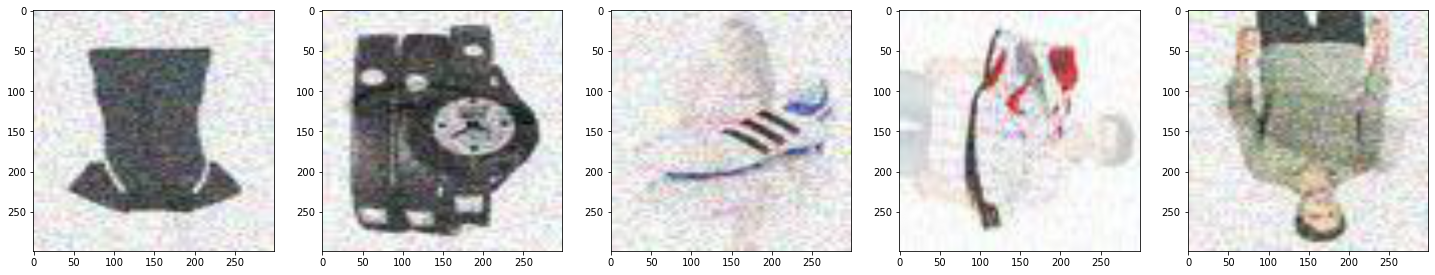

In [25]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [27]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    return K.mean(f1)

In [28]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [29]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=27)

model.summary()

219062272/219055592 [==============================] - 5s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_____________________________________________________

In [30]:
checkpointer = ModelCheckpoint(
    '/kaggle/working/InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=15, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.1051 - acc: 0.5950 - f1: 0.0805
Epoch 00001: val_loss improved from inf to 0.06620, saving model to /kaggle/working/InceptionResNetV2.model
100/100 [==============================] - 145s 1s/step - loss: 0.1051 - acc: 0.5950 - f1: 0.0805 - val_loss: 0.0662 - val_acc: 0.7344 - val_f1: 0.1699
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.0710 - acc: 0.6980 - f1: 0.1130
Epoch 00002: val_loss improved from 0.06620 to 0.05701, saving model to /kaggle/working/InceptionResNetV2.model
100/100 [==============================] - 143s 1s/step - loss: 0.0710 - acc: 0.6980 - f1: 0.1130 - val_loss: 0.0570 - val_acc: 0.7500 - val_f1: 0.2031
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.0658 - acc: 0.7170 - f1: 0.1162
Epoch 00003: val_loss did not improve from 0.05701
100/100 [==============================] - 21s 208ms/step - loss: 0.0658 - acc: 0.7170 - f1: 0.1162 - val_loss: 0

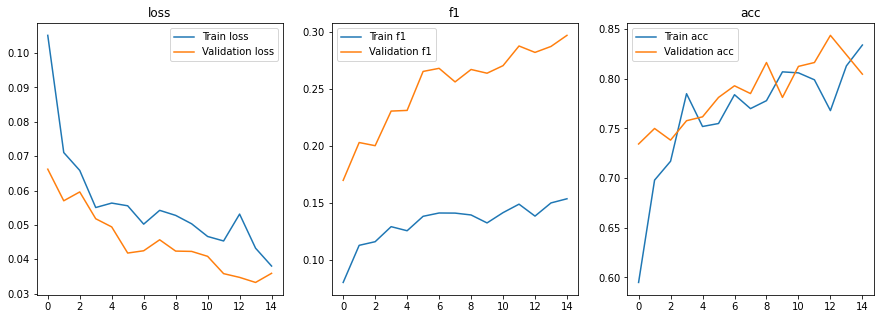

In [31]:
show_history(history)

In [32]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=200, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 0.1081 - acc: 0.4880 - f1: 0.0689
Epoch 00001: val_loss did not improve from 0.03326
100/100 [==============================] - 30s 300ms/step - loss: 0.1081 - acc: 0.4880 - f1: 0.0689 - val_loss: 0.0648 - val_acc: 0.7461 - val_f1: 0.2182
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 0.0784 - acc: 0.6630 - f1: 0.0964
Epoch 00002: val_loss did not improve from 0.03326
100/100 [==============================] - 27s 266ms/step - loss: 0.0784 - acc: 0.6630 - f1: 0.0964 - val_loss: 0.1601 - val_acc: 0.0742 - val_f1: 0.0378
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 0.0695 - acc: 0.6970 - f1: 0.1138
Epoch 00003: val_loss did not improve from 0.03326
100/100 [==============================] - 27s 266ms/step - loss: 0.0695 - acc: 0.6970 - f1: 0.1138 - val_loss: 0.1330 - val_acc: 0.6680 - val_f1: 0.1510
Epoch 4/200
100/100 [==============================] - ETA: 0s - loss:

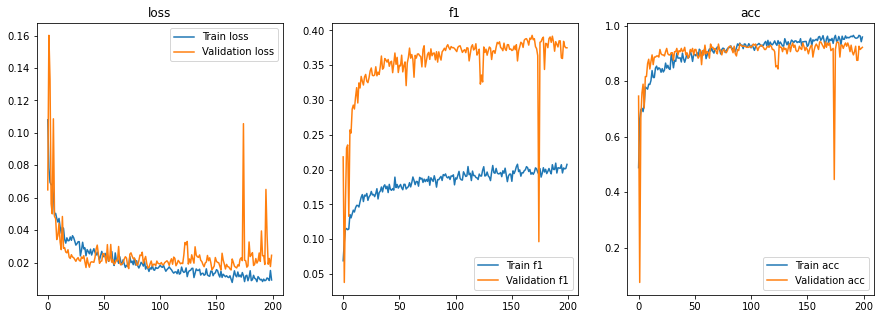

In [33]:
show_history(history)

In [34]:
model = load_model(
    '/kaggle/working/InceptionResNetV2.model', 
    custom_objects={'f1': f1})

In [35]:
train_data = pd.read_csv('/kaggle/input/uw-cs480-fall20/train.csv')
predicted = []
prob_pred = []
labels = []
for name,label in zip(train_data['id'],train_data['category']):
    labels.append(label)
    path = os.path.join('/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/', str(name))
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    prob_pred.append(score_predict)
    label_predict = np.argmax(score_predict)
    predicted.append(label_predict)

In [36]:
test_data = pd.read_csv('/kaggle/input/uw-cs480-fall20/test.csv')
predicted_t = []
prob_pred_t = []
for name in tqdm(test_data['id']):
    path = os.path.join('/kaggle/input/uw-cs480-fall20/suffled-images/shuffled-images/', str(name))
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict_t = model.predict(image[np.newaxis])[0]
    prob_pred_t.append(score_predict_t)

100%|██████████| 21628/21628 [27:07<00:00, 13.29it/s]


Meta - learner (SVM)

In [37]:
label_idx=[]
np.concatenate((prob_pred,prob_p),axis=1)
for idx,i in enumerate(labels):
    label_idx.append(wordIndex(i))

In [38]:
np.concatenate((prob_pred_t,prob_t),axis=1)        

array([[1.9208343e-11, 3.4742281e-12, 5.9200068e-11, ..., 4.6289277e-01,
        4.5610380e-01, 2.9583830e-01],
       [2.8616329e-21, 4.0297249e-18, 1.0131665e-15, ..., 9.9934351e-01,
        2.6005346e-01, 1.2205982e-01],
       [3.3746659e-09, 5.9962425e-13, 6.6975424e-08, ..., 4.6886891e-01,
        8.6811471e-01, 6.6807568e-01],
       ...,
       [1.7462828e-05, 8.4124455e-05, 6.1283342e-04, ..., 9.9993700e-01,
        3.4097582e-01, 2.2836888e-01],
       [6.6533175e-06, 2.7334163e-06, 2.3234502e-06, ..., 6.8505108e-02,
        2.5205070e-01, 4.8301375e-01],
       [3.5604783e-03, 5.1882154e-07, 9.9566603e-01, ..., 4.7333622e-01,
        5.6157899e-01, 3.9732999e-01]], dtype=float32)

In [39]:
# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
 
X_train, X_test, y_train, y_test = train_test_split(prob_pred, label_idx, random_state = 0) 

# training a linear SVM classifier 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 

# model accuracy for X_test 
accuracy = svm_model_linear.score(X_test, y_test) 

# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 


In [40]:
svm_predictions = svm_model_linear.predict(prob_pred_t)

In [41]:
with open('/kaggle/input/uw-cs480-fall20/test.csv', 'r') as f:
    test_data = pd.read_csv(f)
with open("output.csv", 'w+') as f:
    fieldnames = ['id', 'category']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for i,ea in enumerate(svm_predictions):
        pred_cat=cat[ea]
        writer.writerow({'id': test_data['id'][i], 'category': pred_cat})
        